In [4]:
# Članek: https://www.mdpi.com/2076-3417/11/8/3603/htm
# Podatkovna zbirka: http://www.openslr.org/33/

# Base
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import scipy
import seaborn
import sys
import tarfile
import shutil
import h5py

# Keras, Classification, Audio, Features
import keras
from keras import models
from keras import layers
from sklearn.svm import SVC
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
import librosa
import librosa.display

# Preprocessing, Metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score

# Parameters
n_speakers = 200

In [5]:
# Extract data
file = tarfile.open('data_aishell.tgz')

# Index of speaker tars
index = list(filter(lambda x: '.tar.gz' in x, file.getnames()))
index.sort()

print("Num of speakers: ", np.shape(index))

# Extract first n_speakers
for filename in index[0:n_speakers]:
    file.extract(filename, './')
    
    file_speaker = tarfile.open(filename)
    file_speaker.extractall('./')
    file_speaker.close()

# Clean
file.close()
shutil.rmtree("./data_aishell")

Num of speakers:  (400,)


In [4]:
# Get file names of recordings for individual speakers
f_speakers = []
f_recordings = []

for folder in os.listdir("train"):
    # Speaker ID
    f_speakers.append(folder)

    # Recordings  
    f_recordings.append(os.listdir(os.path.join("train", folder)))

Num. of recs per speaker: 352.05 +- 10.6 [317 - 365]


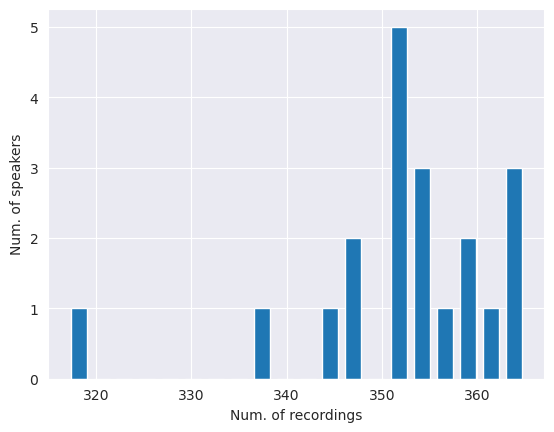

In [5]:
# Plot histogram of the distribution of the number of recordings per speaker
rec_per_speaker = [len(r) for r in f_recordings]

print(f"Num. of recs per speaker: {np.mean(rec_per_speaker)} +- {np.std(rec_per_speaker) :.1f} [{np.min(rec_per_speaker)} - {np.max(rec_per_speaker)}]")

plt.figure()
plt.hist(rec_per_speaker, bins=n_speakers, rwidth=0.7)
plt.xlabel("Num. of recordings")
plt.ylabel("Num. of speakers")
plt.show()

In [6]:
# Load first recording of first speaker
y, fs = librosa.load(os.path.join("train", f_speakers[0], f_recordings[0][0]), sr=None)

print(f"Sampling freq: {fs} Hz")
print(f"Length: {len(y) / fs :.2f} s")

Sampling freq: 16000 Hz
Length: 6.54 s


In [7]:
# Load all recordings and check basic data
data_prop = { "fs": [], "len": []}

for i_s, s in enumerate(f_speakers):
    for i_r, r in enumerate(f_recordings[i_s]):
        print(f"Speaker: {i_s + 1 :04}/{len(f_speakers) :04}, Rec: {i_r + 1 :04}/{len(f_recordings[i_s]) :04}", end='\r')
        
        y, fs = librosa.load(os.path.join("train", s, r), sr=None)

        data_prop["fs"].append(fs)
        data_prop["len"].append(len(y) / fs)

print(f"Sampling freq: {np.mean(data_prop['fs'])} [{np.min(data_prop['fs'])} - {np.max(data_prop['fs'])}] Hz")
print(f"Length: {np.mean(data_prop['len']) :.2f} [{np.min(data_prop['len']) :.2f} - {np.max(data_prop['len']) :.2f}] s")

Sampling freq: 16000.0 [16000 - 16000] Hz
Length: 4.69 [1.34 - 12.54] s


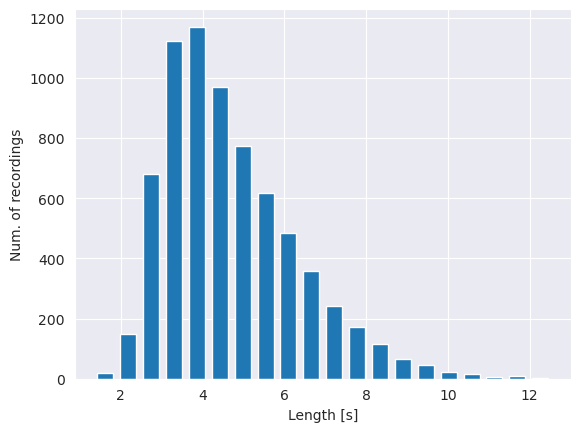

In [8]:
# Plot histogram of the distribution of the number of recordings regarding their length
plt.figure()
plt.hist(data_prop["len"], bins=n_speakers, rwidth=0.7)
plt.xlabel("Length [s]")
plt.ylabel("Num. of recordings")
plt.show()

(40, 409)


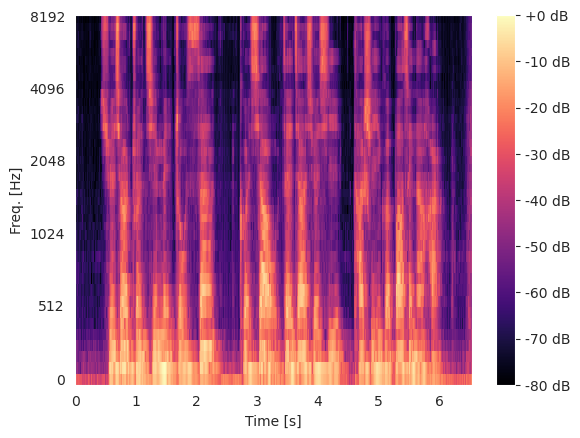

In [9]:
# Feature extraction
# Load first recording of first speaker
y, fs = librosa.load(os.path.join("train", f_speakers[0], f_recordings[0][0]), sr=None)

# Hamming, Window:32ms (512 samples), Stride:16ms (256 samples), NFFT:512
n_fft = 512
hop_length = 256
n_mel_filters = 40

# Parameters!
mel_spec = librosa.feature.melspectrogram(y=y, sr=fs, n_fft=n_fft, hop_length=hop_length, window=scipy.signal.windows.hamming, n_mels=n_mel_filters)
mel_spec_dB = librosa.power_to_db(mel_spec, ref=np.max)

# What does the shape mean?
print(mel_spec_dB.shape)

# Mel-spectrogram
plt.figure()
librosa.display.specshow(mel_spec_dB, sr=fs, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.xlabel("Time [s]")
plt.ylabel("Freq. [Hz]")
plt.show()

In [10]:
# Feature extraction
min_rec_len = 32000 # Min 2 sec of recording
n_frames = min_rec_len // hop_length + 1

data = []
data_labels = []

# For each speaker
for i_s, s in enumerate(f_speakers):
    # For each recording
    for i_r, r in enumerate(f_recordings[i_s]):
        print(f"Speaker: {i_s + 1 :04}/{len(f_speakers) :04}, Rec: {i_r + 1 :04}/{len(f_recordings[i_s]) :04}", end='\r')
        
        # Load recording
        y, fs = librosa.load(os.path.join("train", s, r), sr=None)

        # Check length
        if len(y) < min_rec_len:
            print(f"Recording {r} is too short ({len(y)}) - padding with zeros ({min_rec_len - len(y)})")
            y = np.append(y, np.zeros((min_rec_len - len(y), )))

        # Take only first two seconds of signal
        y = y[0:min_rec_len]

        # Mel-spectrogram - Parameters!
        mel_spec = librosa.feature.melspectrogram(y=y, sr=fs, n_fft=n_fft, hop_length=hop_length, window=scipy.signal.windows.hamming, n_mels=n_mel_filters)
        mel_spec_dB = librosa.power_to_db(mel_spec, ref=np.max)

        # Data and Label
        data.append(mel_spec_dB)
        data_labels.append(i_s) # Not the original label

# Save to h5 file
hf = h5py.File('dataset.h5', 'w')
hf.create_dataset('data', data=data)
hf.create_dataset('data_labels', data=data_labels)
hf.close()

Recording BAC009S0004W0320.wav is too short (30176) - padding with zeros (1824)
Recording BAC009S0004W0433.wav is too short (22447) - padding with zeros (9553)
Recording BAC009S0004W0421.wav is too short (30367) - padding with zeros (1633)
Recording BAC009S0004W0420.wav is too short (29408) - padding with zeros (2592)
Recording BAC009S0004W0424.wav is too short (31726) - padding with zeros (274)
Recording BAC009S0004W0416.wav is too short (28640) - padding with zeros (3360)
Recording BAC009S0004W0430.wav is too short (30752) - padding with zeros (1248)
Recording BAC009S0004W0374.wav is too short (30559) - padding with zeros (1441)
Recording BAC009S0004W0256.wav is too short (23984) - padding with zeros (8016)
Recording BAC009S0007W0254.wav is too short (26832) - padding with zeros (5168)
Recording BAC009S0017W0421.wav is too short (27965) - padding with zeros (4035)
Recording BAC009S0018W0406.wav is too short (31121) - padding with zeros (879)
Recording BAC009S0002W0272.wav is too shor

In [11]:
# Load dataset from h5 file
hf = h5py.File('dataset.h5', 'r')

data = hf.get('data')
data = np.array(data)

data_labels = hf.get('data_labels')
data_labels = np.array(data_labels)

# Samples, MelFilters, NoOfWindows (Frames)
print('Data size:', np.shape(data))

# Samples
print('Data_labels size:', np.shape(data_labels))

hf.close()

Data size: (7041, 40, 126)
Data_labels size: (7041,)


Train: (4224,)
Test: (1409,)
Val: (1408,)


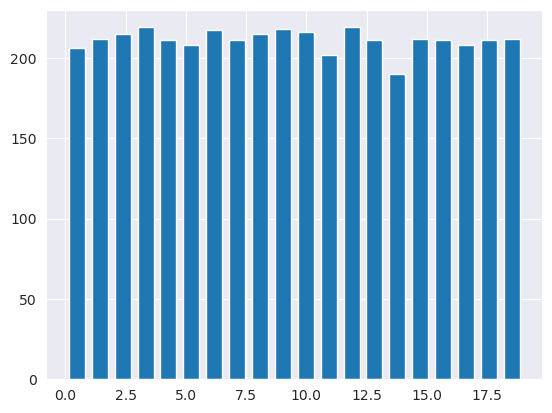

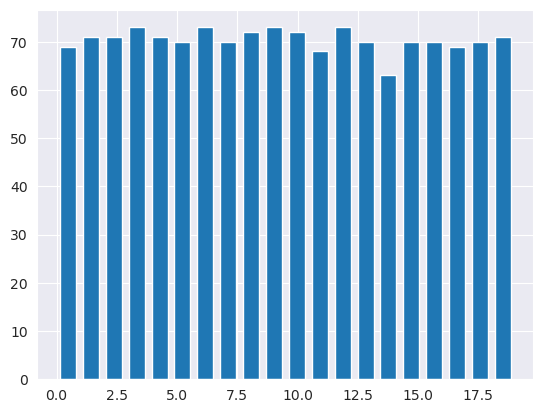

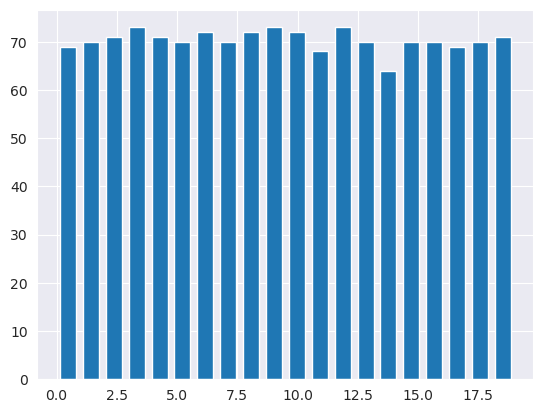

In [12]:
# Scale
scaler = MinMaxScaler()
X = scaler.fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)

# Split into test and train
X_train, X_test, y_train, y_test = train_test_split(X, data_labels, test_size=0.2, stratify=data_labels)

# Split into train and valid
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train)

# Sizes
print('Train:', np.shape(y_train))
print('Test:', np.shape(y_test))
print('Val:', np.shape(y_val))

plt.figure()
plt.hist(y_train, bins=n_speakers, rwidth=0.7)
plt.show()
plt.figure()
plt.hist(y_test, bins=n_speakers, rwidth=0.7)
plt.show()
plt.figure()
plt.hist(y_val, bins=n_speakers, rwidth=0.7)
plt.show()

In [13]:
# NN
model = models.Sequential()
model.add(layers.Input((np.shape(data)[1], np.shape(data)[2], 1)))
model.add(layers.Conv2D(8, (3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))) # Stride - window shifted by given number along each dimension
model.add(layers.Reshape((-1, 496))) # The layer for converting 4D into 3D that GRU can accept. Why (-1,1984)?
model.add(layers.GRU(8, activation='relu', return_sequences=True))
model.add(layers.GRU(8, activation='relu'))
model.add(layers.Dense(n_speakers))

# CategoricalCrossentropy - labels in a one-hot representation
# SparseCategoricalCrossentropy - labels as integers

# from_logits=True - output values not normalized (without softmax in the last layer)
# from_logits=False - output values normalized (with softmax in the last layer)

opt = keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metr = keras.metrics.SparseCategoricalAccuracy()
model.compile(optimizer=opt, loss=loss, metrics=[metr])

model.summary()

I0000 00:00:1750380193.430533   83836 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8384 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1
W0000 00:00:1750380193.675748   84797 gpu_backend_lib.cc:579] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  ipykernel_launcher.runfiles/cuda_nvcc
  ipykern/cuda_nvcc
  
  /usr/local/cuda
  /home/aljaz/miniconda3/envs/07_mfcc_in_nm/lib/python3.10/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc
  /home/aljaz/miniconda3/envs/07_mfcc_in_nm/lib/python3.10/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc
  /home/aljaz/miniconda3/envs/07_mfcc_in_nm/lib/python3.10/site-packages/tensorflow/python/platform/../../cuda
  .
You can choose

UnknownError: {{function_node __wrapped__Sign_device_/job:localhost/replica:0/task:0/device:GPU:0}} JIT compilation failed. [Op:Sign] name: 

In [14]:
# Stopping criterion to avoid overfitting
# patience: Number of epochs with no improvement after which training will be stopped.
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Save best weights
model_checkpoint = ModelCheckpoint("rnn.weights.h5", save_best_only=True, save_weights_only=True)

# Train
t_epochs = 10
b_size = 8
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=t_epochs, batch_size=b_size, callbacks=[early_stopping, model_checkpoint])

# Load best weights
model.load_weights("rnn.weights.h5")

ValueError: You must call `compile()` before using the model.

In [ ]:
# Lets observe the loss metric on both the training (blue) and validation (orange) set
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [ ]:
plt.figure()
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.show()

In [ ]:
# Now to evaluate our model on train and test data

# Train
test_loss, test_acc = model.evaluate(X_train, y_train, verbose=0)
print('Acc train: %.3f' % test_acc)

# Test
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Acc test: %.3f' % test_acc)

In [ ]:
# Test NN
# Predictions for additional analysis
predictions = model.predict(X_test)

# Confusion matrix
predicted_labels = np.argmax(predictions, axis=1)
conf = confusion_matrix(y_test, predicted_labels) # Not normalized! To normalize add normalize="pred"

plt.figure()
seaborn.heatmap(conf, xticklabels=range(0, n_speakers), yticklabels=range(0, n_speakers), cmap="viridis")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

plt.figure()
seaborn.heatmap(conf, xticklabels=range(0, n_speakers), yticklabels=range(0, n_speakers), cmap="viridis", annot=True)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()